In [70]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

In [95]:
dataset = pd.read_csv('70featuresTrainNum881.csv',index_col=0)
test = pd.read_csv('test.csv')
PassengerId = test['PassengerId']
train_len = 881
print dataset.columns

Index([u'Survived', u'Age', u'Fare', u'Parch', u'Sex', u'SibSp',
       u'Name_length', u'NlengthD', u'Fsize', u'Single', u'SmallF', u'MedF',
       u'LargeF', u'Title_0', u'Title_1', u'Title_2', u'Title_3', u'Em_C',
       u'Em_Q', u'Em_S', u'Cabin_A', u'Cabin_B', u'Cabin_C', u'Cabin_D',
       u'Cabin_E', u'Cabin_F', u'Cabin_G', u'Cabin_T', u'Cabin_X', u'children',
       u'old', u'T_A', u'T_A4', u'T_A5', u'T_AQ3', u'T_AQ4', u'T_AS', u'T_C',
       u'T_CA', u'T_CASOTON', u'T_FC', u'T_FCC', u'T_Fa', u'T_LINE', u'T_LP',
       u'T_PC', u'T_PP', u'T_PPP', u'T_SC', u'T_SCA3', u'T_SCA4', u'T_SCAH',
       u'T_SCOW', u'T_SCPARIS', u'T_SCParis', u'T_SOC', u'T_SOP', u'T_SOPP',
       u'T_SOTONO2', u'T_SOTONOQ', u'T_SP', u'T_STONO', u'T_STONO2',
       u'T_STONOQ', u'T_SWPP', u'T_WC', u'T_WEP', u'T_X', u'Pc_1', u'Pc_2',
       u'Pc_3'],
      dtype='object')


In [118]:
pdtest = dataset[train_len:].drop(labels=["Survived"],axis = 1)
y_train = dataset[:train_len]["Survived"].values.astype(int)
pdx_train = dataset[:train_len].drop(labels = ["Survived"],axis = 1)

 
skb = SelectKBest(chi2, k=50).fit(dataset[:train_len].drop(labels = ["Survived"],axis = 1),
                                dataset[:train_len]["Survived"])
mask = skb.get_support()
print pdtest.shape
print len(mask)
print dataset.columns[mask].values[1:]
test = pdtest[dataset.columns[mask].values[1:]].values
x_train = pdx_train[dataset.columns[mask].values[1:]].values

xtrain, xtest, ytrain, ytest = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
print x_train.shape
print y_train.shape
print test.shape
print xtrain.shape
print ytrain.shape
print xtest.shape
print ytest.shape

(418, 70)
70
['Age' 'Fare' 'Parch' 'SibSp' 'Name_length' 'NlengthD' 'Fsize' 'Single'
 'SmallF' 'MedF' 'LargeF' 'Title_0' 'Title_2' 'Title_3' 'Em_Q' 'Em_S'
 'Cabin_A' 'Cabin_B' 'Cabin_C' 'Cabin_D' 'Cabin_E' 'Cabin_G' 'Cabin_T'
 'Cabin_X' 'children' 'T_A' 'T_A4' 'T_AQ4' 'T_CA' 'T_CASOTON' 'T_FC'
 'T_FCC' 'T_LP' 'T_PC' 'T_PPP' 'T_SCA3' 'T_SCA4' 'T_SCAH' 'T_SCParis'
 'T_SOC' 'T_SOP' 'T_SOPP' 'T_SOTONO2' 'T_SOTONOQ' 'T_STONOQ' 'T_SWPP' 'T_X'
 'Pc_1' 'Pc_2']
(881, 49)
(881,)
(418, 49)
(590, 49)
(590,)
(291, 49)
(291,)


In [ ]:
param_grid = dict(gamma=np.logspace(-3, 3, 100), C=np.logspace(-3, 3, 100),kernel=['rbf'])
cv = StratifiedKFold(n_splits=10,random_state=42)
gridsvc2 = GridSearchCV(SVC(), param_grid=param_grid, cv=cv,n_jobs=-1)
gridsvc2.fit(x_train, y_train)
print("The best parameters are %s with a score of %0.8f"% \
      (gridsvc2.best_params_, gridsvc2.best_score_))

#print gridsvc2.cv_results_['param_C']
#print gridsvc2.cv_results_['param_gamma']
#print gridsvc2.cv_results_['mean_test_score']
#sns.barplot(x='param_C',y='mean_test_score',hue='param_gamma',data=gridsvc2.cv_results_)

In [394]:
parameter_grid = {
             'max_depth' : [4, 5,6,7, 8,9,10],
             'n_estimators': [1000],
             'max_features' : ['sqrt', 'log2'],
             'min_samples_split': [2, 3, 4,5,6,7,8,9,10],
             'min_samples_leaf': [2, 3, 4,5,6,7,8,9,10],
             'bootstrap': [True, False],
             }
rft = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
parameter_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], 
              "min_samples_split" : [2, 4, 10, 12, 16], 
              "n_estimators": [50, 100, 400, 700, 1000]}

grid_search = GridSearchCV(estimator=rft,
                           scoring='accuracy',
                           param_grid=parameter_grid,n_jobs=-1,
                           cv=StratifiedKFold(n_splits=5,random_state=42), verbose = 1)

grid_search.fit(x_train, y_train)
parameters = grid_search.best_params_

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 14.6min finished


Best score: 0.837684449489
Best parameters: {'min_samples_split': 10, 'n_estimators': 400, 'criterion': 'entropy', 'min_samples_leaf': 1}


In [395]:
from sklearn.tree import DecisionTreeClassifier
adaDTC = AdaBoostClassifier(DecisionTreeClassifier(), random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[50, 100, 400, 700, 1000],
              "learning_rate":  [0.0001,0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, 
                        cv=StratifiedKFold(n_splits=5,random_state=42), 
                        scoring="accuracy", n_jobs= -1, verbose = 1)

gsadaDTC.fit(x_train,y_train)

print gsadaDTC.best_score_
print gsadaDTC.best_params_

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  9.0min finished


0.805902383655
{'n_estimators': 1000, 'base_estimator__criterion': 'entropy', 'learning_rate': 0.3, 'algorithm': 'SAMME.R', 'base_estimator__splitter': 'best'}


In [396]:
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 2,3,4,5,6,7,8,9, 10],
              "min_samples_split": [2,3,4,5,6,7,8,9, 10],
              "min_samples_leaf": [1, 2,3,4,5,6,7,8,9, 10],
              "bootstrap": [False],
              "n_estimators" :[50, 100, 400, 700, 1000],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, 
                      cv=StratifiedKFold(n_splits=5,random_state=42), 
                      scoring="accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(x_train,y_train)


# Best score
print gsExtC.best_score_
print gsExtC.best_params_

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 63.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 86.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 113.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 144.5min
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed: 161.3min finished


0.83087400681
{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 7, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}


In [397]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [50, 100, 400, 700, 1000],
              'learning_rate': [0.0001,0.001, 0.01, 0.1, 0.2, 0.3,1.5],
              'max_depth': [4, 5,6,7,8],
              'min_samples_leaf': [100,125,150,200,250,300],
              'max_features': [0.3, 0.2,0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, 
                     cv=StratifiedKFold(n_splits=5,random_state=42), 
                     scoring="accuracy", n_jobs= -1, verbose = 1)

gsGBC.fit(x_train,y_train)


print gsGBC.best_score_
print gsGBC.best_params_

Fitting 5 folds for each of 630 candidates, totalling 3150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 3150 out of 3150 | elapsed:  9.2min finished


0.836549375709
{'loss': 'deviance', 'learning_rate': 0.1, 'min_samples_leaf': 100, 'n_estimators': 1000, 'max_features': 0.1, 'max_depth': 7}


In [71]:
for i in range(5):
    print grid_search.cv_results_['split%d_test_score' % i]
grid_search.cv_results_['mean_test_score']

[ 0.84180791  0.83615819  0.84180791 ...,  0.83050847  0.83615819
  0.83050847]
[ 0.81818182  0.81818182  0.81818182 ...,  0.8125      0.8125      0.8125    ]
[ 0.8125  0.8125  0.8125 ...,  0.8125  0.8125  0.8125]
[ 0.79545455  0.79545455  0.79545455 ...,  0.8125      0.8125      0.80681818]
[ 0.83522727  0.84090909  0.84090909 ...,  0.84659091  0.84659091
  0.84659091]


array([ 0.82065834,  0.82065834,  0.82179342, ...,  0.82292849,
        0.82406356,  0.82179342])

In [119]:
from sklearn.metrics import accuracy_score
SEED=42
n_splits = 5
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((x_train.shape[0],))
    skf = StratifiedKFold(n_splits=n_splits)
    skf.get_n_splits(x_train,y_train)
    oof_test = np.zeros((x_test.shape[0],))

    for train_index, test_index in skf.split(x_train,y_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test += clf.predict(x_test)
        

    oof_test = oof_test / n_splits
    print accuracy_score(y_train,oof_train.reshape(-1))
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [120]:
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}
et_params = {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 
             'min_samples_split': 9, 'criterion': 'gini', 'max_features': 2, 
             'max_depth': None}
#0.829738933031

et_params = {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 500, 
             'min_samples_split': 7, 'criterion': 'gini', 'max_features': 1, 
             'max_depth': None}
#0.83087400681
et = ExtraTreesClassifier(**et_params)
et_oof_train, et_oof_test = get_oof(et,x_train,y_train,test)

0.820658342792


In [121]:
rf_params = {'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 700, 
             'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 6}
rf_params = {'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 1000, 'min_samples_split': 2
             ,'max_features': 'sqrt', 'max_depth': 6}
#82
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
#0.850170261067 
rf = RandomForestClassifier(**rf_params)
'''rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=16,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)'''
rf_oof_train, rf_oof_test = get_oof(rf,x_train,y_train,test)

0.845629965948


In [122]:
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.05
}
'''ada_params = {'n_estimators': 500, 
              'learning_rate': 0.3, 'algorithm': 'SAMME.R', 
              }'''
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),**ada_params)
ada = AdaBoostClassifier(**ada_params)
ada_oof_train, ada_oof_test = get_oof(ada,x_train,y_train,test)

0.819523269012


In [123]:
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}
'''gb_params = {'loss': 'deviance', 'learning_rate': 0.1, 'min_samples_leaf': 100,
             'n_estimators': 1000, 'max_features': 0.1, 'max_depth': 7}
#0.83200908059
gb_params = {'loss': 'deviance', 'learning_rate': 0.1, 'min_samples_leaf': 100, 
             'n_estimators': 500,'max_features': 0.1, 'max_depth': 7}
#0.836549375709'''
gb = GradientBoostingClassifier(**gb_params)
gb_oof_train, gb_oof_test = get_oof(gb,x_train,y_train,test)

0.800227014756


In [124]:
svc_params = {'kernel': 'rbf', 'C': 46.415888336127821, 'gamma': 0.002009233002565048}
svc_params = {'kernel': 'rbf', 'C': 13.219411484660288, 'gamma': 0.0030538555088334154}
svc_oof_train, svc_oof_test = get_oof(SVC(**svc_params),x_train,y_train,test)

0.822928490352


**Feature importances generated from the different classifiers**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.feature_importances_**. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [86]:
rf_features = rf.feature_importances_
et_features = et.feature_importances_
ada_features = ada.feature_importances_
gb_features = gb.feature_importances_
print len(gb_features)
print gb_features
print len(ada_features)
print et_features
print rf_features

19
[ 0.32942669  0.08040301  0.01877067  0.01491773  0.36245267  0.0278145
  0.01348118  0.01534764  0.00662845  0.00403042  0.00433128  0.03463753
  0.00178252  0.02111159  0.00489692  0.          0.          0.03923991
  0.0207273 ]
19
[ 0.10081183  0.11772846  0.02099274  0.02203727  0.13473929  0.02737304
  0.02044392  0.01386443  0.02231697  0.02458244  0.01625408  0.38317365
  0.00535722  0.01293127  0.02766183  0.00079866  0.          0.01730239
  0.03163052]
[ 0.08303768  0.14913586  0.02327494  0.03354157  0.13881554  0.0636688
  0.02162829  0.0173207   0.01903582  0.02619809  0.01098804  0.35065444
  0.00129272  0.01327252  0.01524143  0.          0.          0.01252722
  0.02036635]


In [87]:
cols = dataset.columns[mask].values[1:]
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'rf': rf_features,
     'et': et_features,
      'ada': ada_features,
    'gb': gb_features
    })
feature_dataframe = feature_dataframe[['features','rf','et','ada','gb']]
feature_dataframe.head()

,features,rf,et,ada,gb
0,Age,0.083038,0.100812,0.190,0.329427
1,Fare,0.149136,0.117728,0.188,0.080403
2,Parch,0.023275,0.020993,0.000,0.018771
3,SibSp,0.033542,0.022037,0.028,0.014918
4,Name_length,0.138816,0.134739,0.144,0.362453


**Interactive feature importances via Plotly scatterplots**

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers 

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe

In [88]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)
feature_dataframe.sort_values('et',ascending=False)
important = feature_dataframe.sort_values('mean',ascending=False)[:20]
print important
important['features'].values

       features        rf        et    ada        gb      mean
11      Title_3  0.350654  0.383174  0.146  0.034638  0.228616
4   Name_length  0.138816  0.134739  0.144  0.362453  0.195002
0           Age  0.083038  0.100812  0.190  0.329427  0.175819
1          Fare  0.149136  0.117728  0.188  0.080403  0.133817
5         Fsize  0.063669  0.027373  0.076  0.027814  0.048714
9        LargeF  0.026198  0.024582  0.046  0.004030  0.025203
10      Title_2  0.010988  0.016254  0.068  0.004331  0.024893
3         SibSp  0.033542  0.022037  0.028  0.014918  0.024624
18         Pc_2  0.020366  0.031631  0.020  0.020727  0.023181
14      Cabin_D  0.015241  0.027662  0.042  0.004897  0.022450
17          T_X  0.012527  0.017302  0.016  0.039240  0.021267
6        Single  0.021628  0.020444  0.016  0.013481  0.017888
2         Parch  0.023275  0.020993  0.000  0.018771  0.015760
8          MedF  0.019036  0.022317  0.000  0.006628  0.011995
13      Cabin_C  0.013273  0.012931  0.000  0.021112  0

array(['Title_3', 'Name_length', 'Age', 'Fare', 'Fsize', 'LargeF',
       'Title_2', 'SibSp', 'Pc_2', 'Cabin_D', 'T_X', 'Single', 'Parch',
       'MedF', 'Cabin_C', 'SmallF', 'Cabin_A', 'Cabin_T', 'T_LP'], dtype=object)

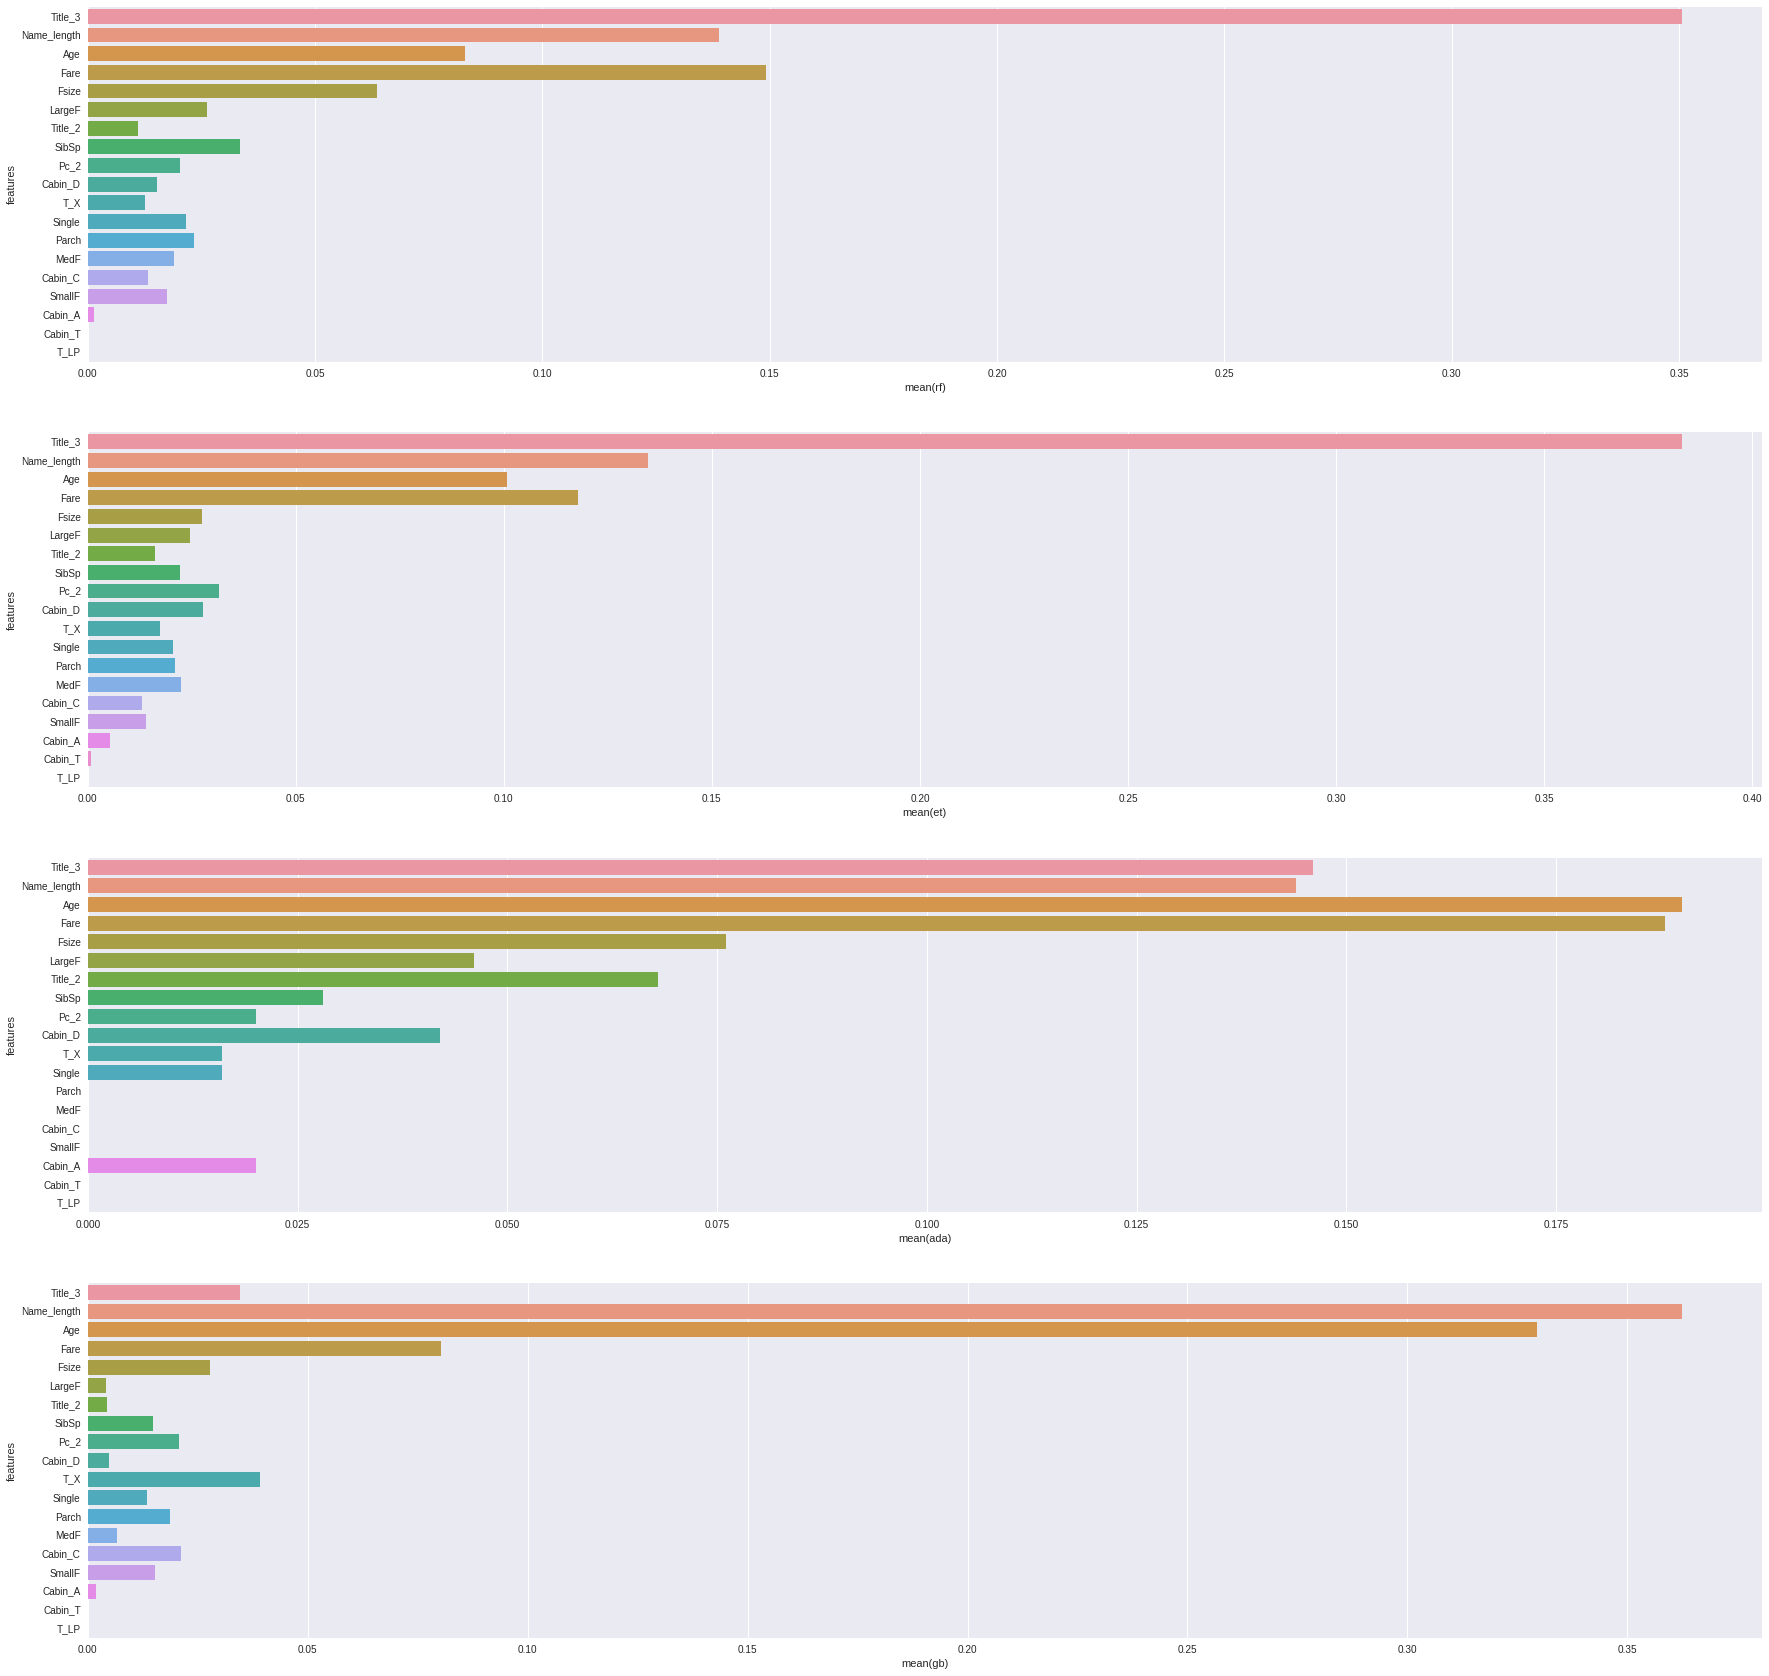

In [89]:
_,ax=plt.subplots(4,1,figsize=(30,30))
for i,classify in enumerate(important.columns.values[1:5:]):
    sns.barplot(y='features',x=classify,data=important,ax=ax[i])

# Second-Level Predictions from the First-level Output

**First-level output as new features**

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [90]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


**Correlation Heatmap of the Second Level Training set**

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

In [125]:
print et_oof_train.shape
x_train_stack = np.concatenate(( et_oof_train, rf_oof_train,gb_oof_train,ada_oof_train,svc_oof_train), axis=1)
x_test_stack = np.concatenate(( et_oof_test, rf_oof_test, gb_oof_test,ada_oof_test,svc_oof_test), axis=1)
print x_train_stack.shape
print x_test_stack.shape

(881, 1)
(881, 5)
(418, 5)


### Second level learning model via XGBoost

Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. For further information about the algorithm, check out the [official documentation][1].

  [1]: https://xgboost.readthedocs.io/en/latest/

Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [126]:
gbm = xgb.XGBClassifier(
 learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train_stack, y_train)
print accuracy_score(gbm.predict(x_train_stack),y_train)
predictions = gbm.predict(x_test_stack)

0.855845629966


In [106]:
print accuracy_score(ytest,predictions)

ValueError: Found input variables with inconsistent numbers of samples: [291, 418]

Just a quick run down of the XGBoost parameters used in the model:

**max_depth** : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

**gamma** : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

**eta** : step size shrinkage used in each boosting step to prevent overfitting

**Producing the Submission file**

Finally having trained and fit all our first-level and second-level models, we can now output the predictions into the proper format for submission to the Titanic competition as follows:

In [127]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
'''StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': rf_oof_test.reshape(-1).astype(int)})'''

StackingSubmission.to_csv("titanic.csv", index=False)

**Steps for Further Improvement**

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels. 

Some additional steps that may be taken to improve one's score could be:

 1. Implementing a good cross-validation strategy in training the models to find optimal parameter values
 2. Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.